# Invariant Ring Slot Attention

**Goal:** In the `Invariant-Slot-Attention` notebook, I built an ISA model, and although I really liked the way this paper encoded the translation invariance into the physics model, I don't know if it's necessarily the _right_ model for this problem, b/c it will not correctly get the center or radius for rings that aren't fully contained inside of our cropped images.

(See below example rings from Florian.)

<img src="flo-esc-rings.png" />


I think if I let the query dimension be $q \in \mathbb{R}^3$ denote the $(x,y,r)$ for each ring, I could compute the ring score based on the distance of each pixel to the ring predicted by the slot.

Note, Lukas was not a super fan of this method b/c he liked the idea of having a general method that could learn any embedding, but I think infusing physics knowledge into our reconstruction is actually super awesome :)

In [11]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from torch.nn import init
from train import train

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
device='cuda:0'
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':3,
    'pixel_mult':0.2,
    'device':device
}

In [17]:
class RingSlotAttention(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 xlow=-0.5,
                 xhigh=0.5,
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 rnn_dim=32,
                 query_dim=3, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block, block attention
        '''
        super().__init__()

        assert query_dim == 3
        
        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.rnn_dim = rnn_dim
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        
        self.toV = torch.nn.Linear(self.hidden_dim, self.rnn_dim)
        self.gru = torch.nn.GRUCell(self.rnn_dim, self.query_dim)

        # CNN
        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
            
        # Grid + query init
        self.abs_grid = self.build_grid()
                   
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots

    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="xy")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        
        grid = torch.FloatTensor( grid ).to(self.device)
        grid = torch.flatten(grid,1,2)
    
        return grid
                
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        queries = mu + sigma * torch.randn(mu.shape, device=self.device)

        return queries
                    
    def attention_and_weights(self,queries):
        
        Nbatch = queries.shape[0]
        xy_grid = self.abs_grid
        
        xy_slots = queries[:,:,:2]
        r_slots = torch.exp(queries[:,:,-1])
        
        # Calculate the vector from the cirlce center -> xy
        logits = xy_slots.unsqueeze(2) - xy_grid.unsqueeze(1)
        
        # Take the length of this vector (L2 norm)
        logits = torch.sqrt(torch.sum(logits**2,axis=-1))

        # Subtract r
        logits = torch.abs( logits - r_slots.unsqueeze(-1) )

        att = torch.nn.functional.softmax(self.softmax_T * logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts
        
    def iterate(self, queries, encoded_data):
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(queries)   
        
        vals = self.toV(encoded_data)
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.rnn_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        return updates.reshape(queries.shape)
        
    def forward(self, data):
    
        # Step 1: Get the encoded data
        encoded_data = self.CNN_encoder(data) # apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten the pixel dims
    
        # Step 2: Initialize the slots
        Nbatch = data.shape[0]
        queries = self.init_slots(data.shape[0]) 
        
        # Step 3: Iterate through the reconstruction
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        att, wts = self.attention_and_weights(queries)   
        
        return queries, att, wts 

In [24]:
m = RingSlotAttention(**hps).to(device)

In [25]:
bs = 2
kwargs = {'isRing': True, 'N_clusters':2,'device':device}
X, Y, mask = make_batch(N_events=2, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [26]:
with torch.no_grad():
    queries, att,wts = m(X)
queries.shape

torch.Size([2, 3, 3])

Training model with 3 slots on 2rings
iter 100 , loss 0.78712857 , lr 5.991687996606173e-06


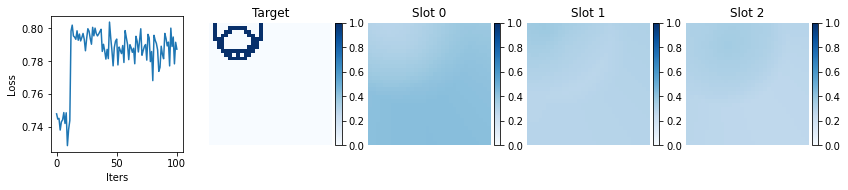

iter 200 , loss 0.7681906 , lr 1.1966775016224833e-05


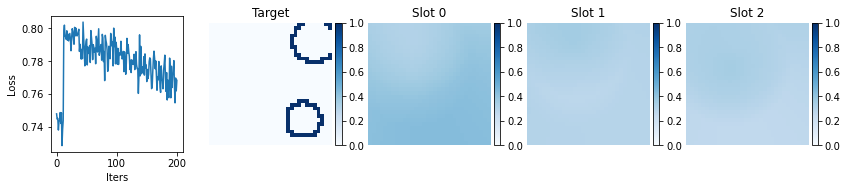

iter 300 , loss 0.75942445 , lr 1.7925295555700243e-05


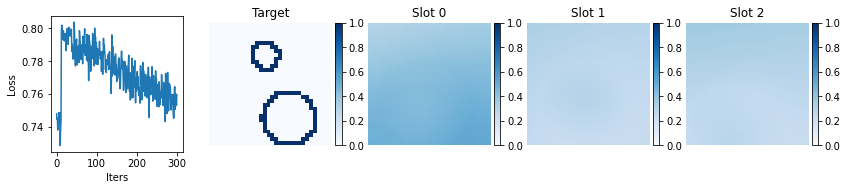

iter 400 , loss 0.7366802 , lr 2.3867284048157144e-05


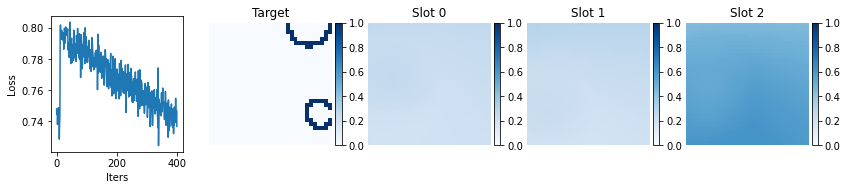

iter 500 , loss 0.57933664 , lr 2.9792774863111075e-05


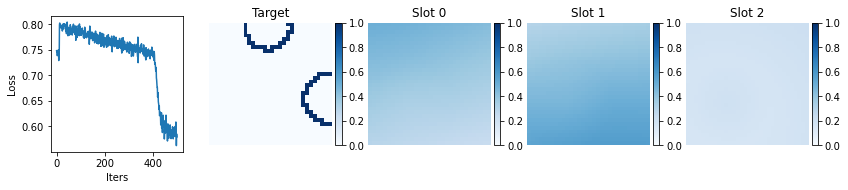

iter 600 , loss 0.5839809 , lr 3.570180230657855e-05


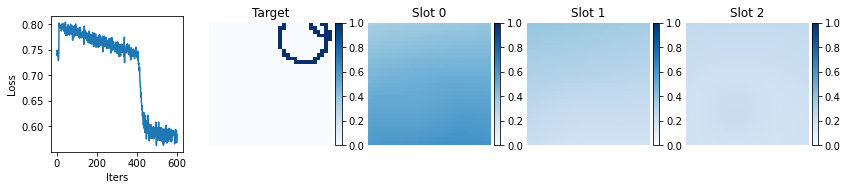

iter 700 , loss 0.5852119 , lr 4.159440062118703e-05


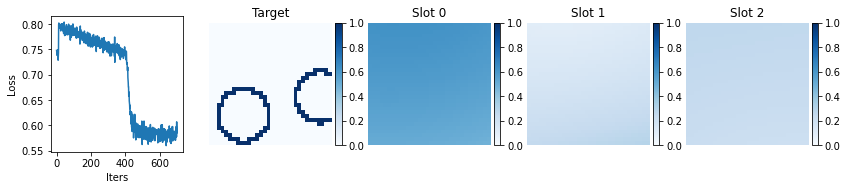

iter 800 , loss 0.592304 , lr 4.7470603986284704e-05


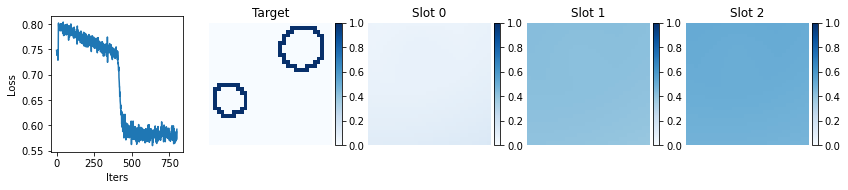

iter 900 , loss 0.5646459 , lr 5.3330446518050114e-05


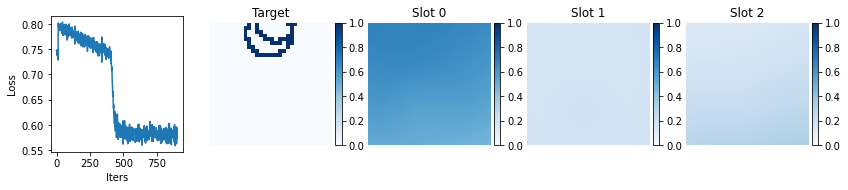

KeyboardInterrupt: 

In [27]:
m, losses = train(m, bs=256, Ntrain=40_000, plot_every=100, device=device)

In [325]:
queries = torch.FloatTensor(np.array(
  [[[.4,.4,.5*np.log(.03)],
   [0,-0.2,.5*np.log(.03)],
   [0,0,.5*np.log(.05)]],
   [[.4,.4,.5*np.log(.03)],
   [0,0,.5*np.log(.03)],
   [0,0,.5*np.log(.05)]]
  ]
))

In [326]:
queries.shape

torch.Size([2, 3, 3])

In [327]:
Y[0]

tensor([[-0.1134,  0.0571,  0.2123],
        [-0.4352, -0.4950,  0.1976]])

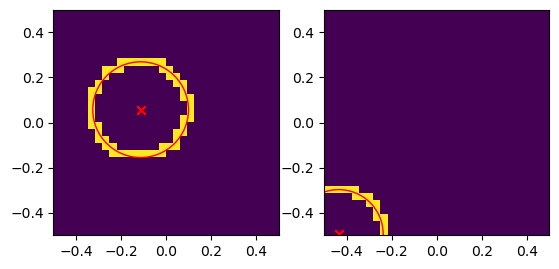

In [367]:
fig, ax = plt.subplots(1,2)

extent = [-0.5,0.5]*2
ax[0].imshow(mask[0,0].numpy(),extent=extent,origin='lower')
ax[1].imshow(mask[0,1].numpy(),extent=extent,origin='lower')

for axi,yi in zip(ax,Y[0]):
    axi.scatter(*yi[:2],marker='x',color='r')
    axi.scatter(*yi[:2],marker='x',color='r')
    circle = Circle(yi[:2],yi[2],fill=False,color='r')
    axi.add_patch(circle)
    
    axi.set_xlim(-0.5,0.5)
    axi.set_ylim(-0.5,0.5)
    
plt.show()

In [332]:
xy_slots = queries[:,:,:2]
r_slots = torch.exp(queries[:,:,-1])

In [333]:
r_slots

tensor([[0.1732, 0.1732, 0.2236],
        [0.1732, 0.1732, 0.2236]])

In [334]:
xy_slots.shape

torch.Size([2, 3, 2])

In [335]:
r_slots.shape

torch.Size([2, 3])

In [336]:
xy_grid = encoded_data[:,:,-2:]
xy_grid.shape

torch.Size([2, 1024, 2])

**Formula for the distance from a circle**

In [352]:
Nbatch = 2

# Calculate the vector from the cirlce center -> xy
logits = xy_slots.unsqueeze(2) - xy_grid.unsqueeze(1)

# Take the length of this vector (L2 norm)
logits = torch.sqrt(torch.sum(logits**2,axis=-1))

# # Subtract r
logits = torch.abs( logits - r_slots.unsqueeze(-1) )

# logits.shape

In [353]:
r_slots

tensor([[0.1732, 0.1732, 0.2236],
        [0.1732, 0.1732, 0.2236]])

In [354]:
torch.sum(logits < 0)

tensor(0)

In [355]:
logits[0].min(),logits[0].max()

(tensor(0.0010, grad_fn=<MinBackward1>),
 tensor(1.0996, grad_fn=<MaxBackward1>))

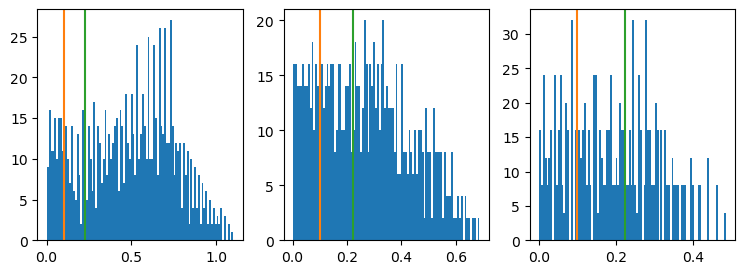

In [359]:
fig, ax = plt.subplots(1,3,figsize=(9,3))

for axi, li in zip(ax,logits[0].detach().numpy()):
    axi.hist(li.flatten(),100,)

    ylim = axi.get_ylim()
    axi.plot([np.sqrt(.01)]*2,ylim)
    axi.plot([np.sqrt(.05)]*2,ylim)
    axi.set_ylim(ylim)
    
plt.show()


In [360]:
xy0 = xy_grid[0].reshape(32,32,2)

In [361]:
cmap =mlp.colorbar.cm.get_cmap('PuOr')

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_78655/3086582264.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap =mlp.colorbar.cm.get_cmap('PuOr')


/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_78655/883032103.py:13: RuntimeWarning: invalid value encountered in sqrt
  circle = Circle(qi[:2],np.sqrt(qi[2]),fill=False,color='k')


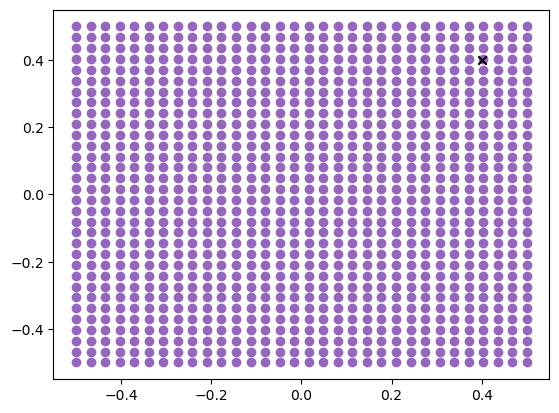

In [362]:
# plt.scatter(*xy_grid[0].detach().numpy().T)

z = logits[0].detach().numpy()
z /= np.max(z)

plt.scatter(*xy_grid[0].detach().numpy()[z[0]>0].T,color='C4')
plt.scatter(*xy_grid[0].detach().numpy()[z[0]<0].T,color='C1')

axi = plt.gca()

qi = queries[0,0].detach().numpy()
axi.scatter(*qi[:2],marker='x',color='k')
circle = Circle(qi[:2],np.sqrt(qi[2]),fill=False,color='k')
axi.add_patch(circle)

plt.show()


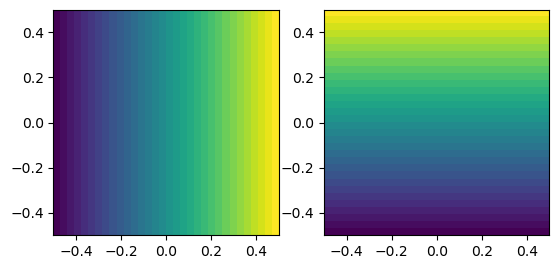

In [364]:
fig, ax = plt.subplots(1,2)

extent = [-0.5,0.5]*2
ax[0].imshow(xy0[:,:,0].detach().numpy(),extent=extent,origin='lower')
ax[1].imshow(xy0[:,:,1].detach().numpy(),extent=extent,origin='lower')

plt.show()

In [365]:
from matplotlib.patches import Circle

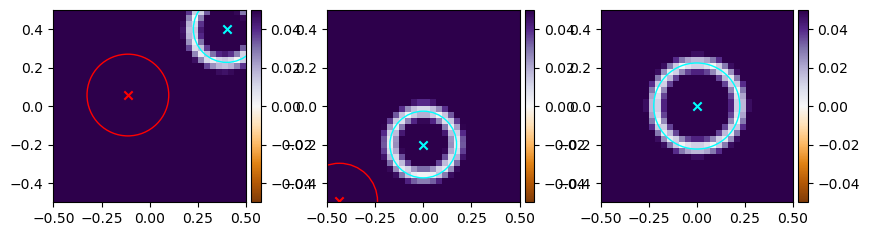

In [366]:
iEvt = 0

fig, ax = plt.subplots(1,3,figsize=(10,2.5))

extent = [-0.5,0.5]*2
for i_slot, (axi,li,qi) in enumerate(zip(ax,logits[iEvt],
                                         queries[iEvt].detach().numpy())):
    
    im = axi.imshow(li.reshape(32,32).detach().numpy(),
                    cmap='PuOr',vmax=.05,vmin=-.05,
                    extent=extent,origin='lower')

    divider = make_axes_locatable(axi)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    
    axi.scatter(*qi[:2],marker='x',color='cyan')
    circle = Circle(qi[:2],np.exp(qi[2]),fill=False,color='cyan')
    axi.add_patch(circle)
        
    
for axi,yi in zip(ax,Y[iEvt]):
    axi.scatter(*yi[:2],marker='x',color='r')
    circle = Circle(yi[:2],yi[2],fill=False,color='r')
    axi.add_patch(circle)
    
    axi.set_xlim(-0.5,0.5)
    axi.set_ylim(-0.5,0.5)
    
plt.show()